# <a id='toc1_'></a>[<span style="color:yellow;">Steganography Example with Camera Image</span>](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [<span style="color:yellow;">Steganography Example with Camera Image</span>](#toc1_)    
- [Step 1: Import libraries](#toc2_)    
- [Step 2: Load the camera image from scikit-image](#toc3_)    
- [Step 3: Convert to numpy array](#toc4_)    
- [Step 4: Create secret message](#toc5_)    
- [Step 5: Steganography functions with overflow protection](#toc6_)    
- [Step 6: Embed message](#toc7_)    
- [Step 7: Original vs stego image](#toc8_)    
- [Step 8: Extract message](#toc9_)    
- [Step 9: Pixel distribution (using histplot)](#toc10_)    
- [Step 10: LSB planes visualization](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Step 1: Import libraries](#toc0_)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage import data  # Import scikit-image's data module

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
print("Libraries imported successfully!")

Libraries imported successfully!


# <a id='toc3_'></a>[Step 2: Load the camera image from scikit-image](#toc0_)

Loading sample camera image from scikit-image...


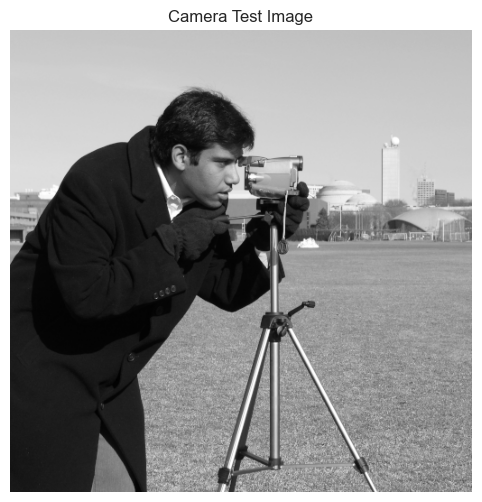

Image size: (512, 512)
Image mode: RGB


In [2]:
print("Loading sample camera image from scikit-image...")
img = data.camera()  # Grayscale image (512x512) # 这是data里的一张图片

# Convert to RGB (since our steganography code expects 3 channels)
img_rgb = np.stack([img] * 3, axis=-1)  # Duplicate across RGB channels # 把同一张灰度图复制三次，并沿着最后一个维度堆叠，形成 (512, 512, 3) 的数组。
img = Image.fromarray(img_rgb.astype(np.uint8)) # img_rgb.astype(np.uint8) 把数据类型转为 uint8（0–255 的整数），确保符合图像格式。把 numpy 数组转换为 PIL.Image 对象，方便后续保存、显示或处理。

# Display the image
plt.figure()
plt.imshow(img)
plt.title('Camera Test Image')
plt.axis('off')
plt.show()

print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")

# <a id='toc4_'></a>[Step 3: Convert to numpy array](#toc0_)

In [3]:
img_arr = np.array(img)
print(f"Numpy array shape: {img_arr.shape}")  # Should be (512, 512, 3)

Numpy array shape: (512, 512, 3)


# <a id='toc5_'></a>[Step 4: Create secret message](#toc0_)

# 隐写一串数字
message = np.array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
print(f"\nSecret message: {message}")

# 隐写字符串
def string_to_binary_array(s: str) -> np.ndarray:
    """
    将字符串转换为 0/1 二进制数组。
    
    参数:
        s (str): 待转换的字符串
    返回:
        np.ndarray: 二进制数组，每个字符 8 位
    """

    # 对每个字符 -> 8位二进制 -> 展平成 0/1 列表
    binary_list = [int(bit) for c in s for bit in format(ord(c), '08b')]
    return np.array(binary_list, dtype=np.uint8)

text = "Hello, world!"  # 你的文字信息
message = string_to_binary_array(text)
print(f"\nSecret message: {message}")

In [4]:
# 隐写彩色图像
def generate_stego_cover_image(width=64, height=64):
    """
    生成适合隐写的随机彩色图像
    """
    # 生成随机整数 0-255，shape=(H, W, 3)
    img_array = np.random.randint(0, 256, size=(height, width, 3), dtype=np.uint8)
    
    # 转成 PIL 图片
    img = Image.fromarray(img_array)
    return img

# 生成并保存
img = generate_stego_cover_image()
img.save("stego_cover.png")
img.show()

In [5]:
def pil_to_binary_array(pil_img):
    """
    将 PIL 图像转成 0/1 二进制数组
    每个像素每个通道 8 位
    """
    # 转 numpy 数组
    img_array = np.array(pil_img)
    
    # 展平并转二进制
    binary_array = np.array([int(bit) 
                             for pixel in img_array.flatten() 
                             for bit in format(pixel, '08b')],
                            dtype=np.uint8)
    return binary_array

In [6]:
insert_img = Image.open("stego_cover.png").convert("RGB")  # 强制转换为 RGB

message = pil_to_binary_array(np.array(insert_img))

print(f"\nSecret message: {message}") 


Secret message: [0 0 0 ... 1 1 1]


# <a id='toc6_'></a>[Step 5: Steganography functions with overflow protection](#toc0_)

In [7]:
def embed_message(image_array, message):
    """Embed message into LSB of red channel (overflow-safe)."""
    flat_img = image_array.reshape(-1, 3).copy()
    
    if len(message) > len(flat_img):
        raise ValueError(f"Message too large for image")
    else:
        print(f"Embedding message of length {len(message)} into image with {len(flat_img)} pixels")
    
    # Use int32 to avoid overflow during operations
    red_channel = flat_img[:len(message), 0].astype(np.int32)
    
    # Vectorized embedding with modulo to stay in 0-255 range
    red_channel[message == 1] = (red_channel[message == 1] | 1) % 256
    red_channel[message == 0] = (red_channel[message == 0] & ~1) % 256
    
    # Convert back to uint8
    flat_img[:len(message), 0] = red_channel.astype(np.uint8)
    return flat_img.reshape(image_array.shape)

def extract_message(stego_array, message_length):
    """Extract message from LSB of red channel."""
    flat_stego = stego_array.reshape(-1, 3)
    return (flat_stego[:message_length, 0] & 1).astype(np.uint8)

# <a id='toc7_'></a>[Step 6: Embed message](#toc0_)

In [8]:
print("\nEmbedding message...")
stego_arr = embed_message(img_arr, message)
stego_img = Image.fromarray(stego_arr.astype(np.uint8))


Embedding message...
Embedding message of length 98304 into image with 262144 pixels


# <a id='toc8_'></a>[Step 7: Original vs stego image](#toc0_)

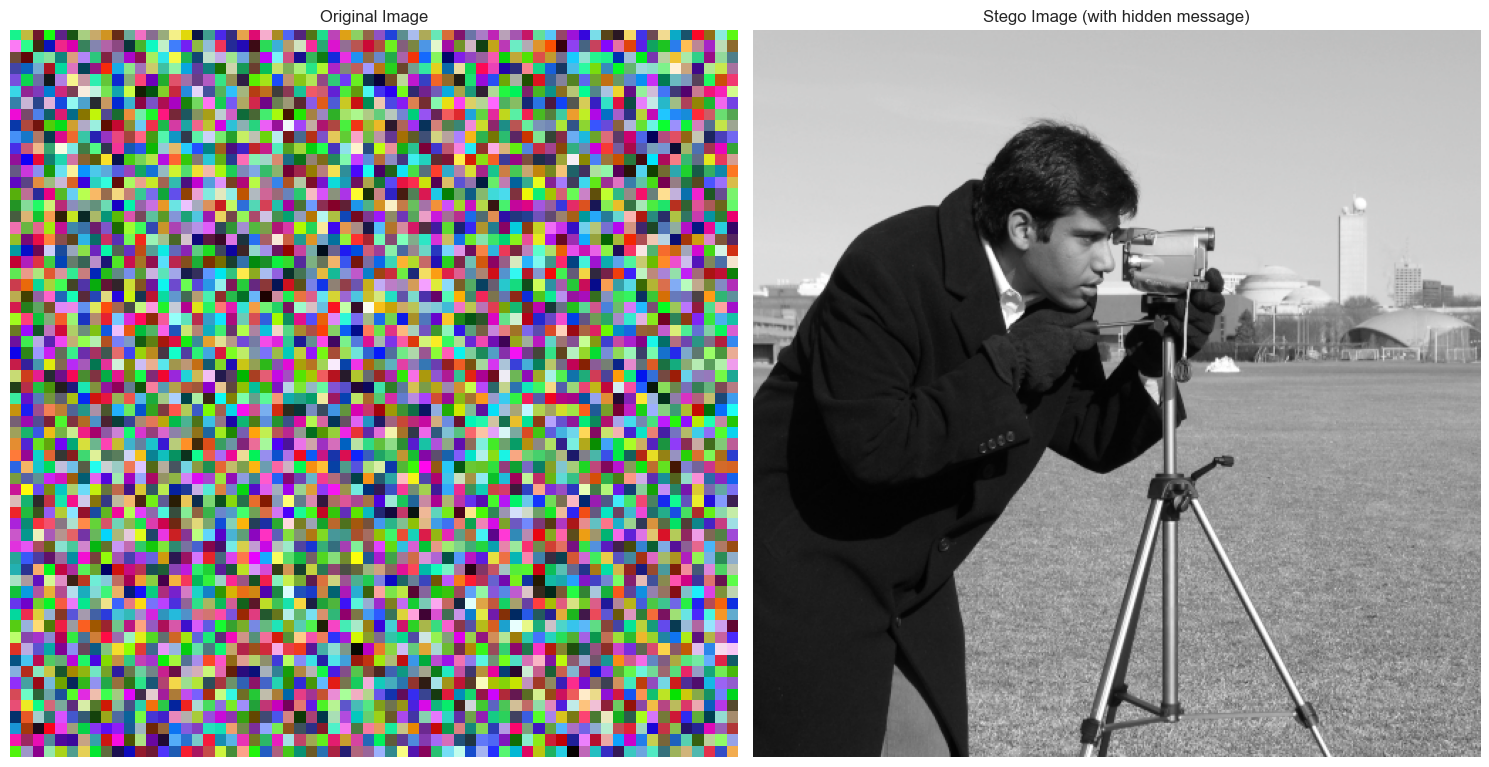

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(stego_img)
ax2.set_title('Stego Image (with hidden message)')
ax2.axis('off')

plt.tight_layout()
plt.show()

# <a id='toc9_'></a>[Step 8: Extract message](#toc0_)

In [10]:
print("\nExtracting message...")
extracted_message = extract_message(stego_arr, len(message))
print(f"Original message: {message}")
print(f"Extracted message: {extracted_message}")
print(f"Match: {np.array_equal(message, extracted_message)}")


Extracting message...
Original message: [0 0 0 ... 1 1 1]
Extracted message: [0 0 0 ... 1 1 1]
Match: True


def binary_array_to_string(binary_array: np.ndarray) -> str:
    """
    将 0/1 二进制数组转换回字符串。
    
    参数:
        binary_array (np.ndarray): 二进制数组，长度必须是 8 的倍数
    返回:
        str: 原始字符串
    """
    # 检查长度是否是 8 的倍数
    if len(binary_array) % 8 != 0:
        raise ValueError("二进制数组长度必须是 8 的倍数")
    
    chars = []
    # 每 8 位转换为一个字符
    for i in range(0, len(binary_array), 8):
        byte = binary_array[i:i+8]
        byte_str = ''.join(str(b) for b in byte)
        chars.append(chr(int(byte_str, 2)))
    
    return ''.join(chars)

extracted_text = binary_array_to_string(extracted_message)
print(f"\nExtracted text: {extracted_text}")

In [11]:
def binary_array_to_pil(binary_array, shape):
    """
    将 0/1 二进制数组还原为 PIL 图片
    参数:
        binary_array: numpy 0/1 数组
        shape: 原始图像 shape, (H, W, 3)
    返回:
        PIL.Image 对象
    """
    H, W, C = shape
    total_pixels = H * W * C
    
    # 检查长度
    if len(binary_array) != total_pixels * 8:
        raise ValueError("二进制数组长度不匹配图像大小")
    
    # 每8位还原为一个像素值
    pixels = []
    for i in range(0, len(binary_array), 8):
        byte_str = ''.join(str(b) for b in binary_array[i:i+8])
        pixels.append(int(byte_str, 2))
    
    img_array = np.array(pixels, dtype=np.uint8).reshape(shape)
    return Image.fromarray(img_array)

restored_img = binary_array_to_pil(message, insert_img.size[::-1] + (3,))  # 注意 PIL 的 size 是 (W,H)
restored_img.show()

# <a id='toc10_'></a>[Step 9: Pixel distribution (using histplot)](#toc0_)

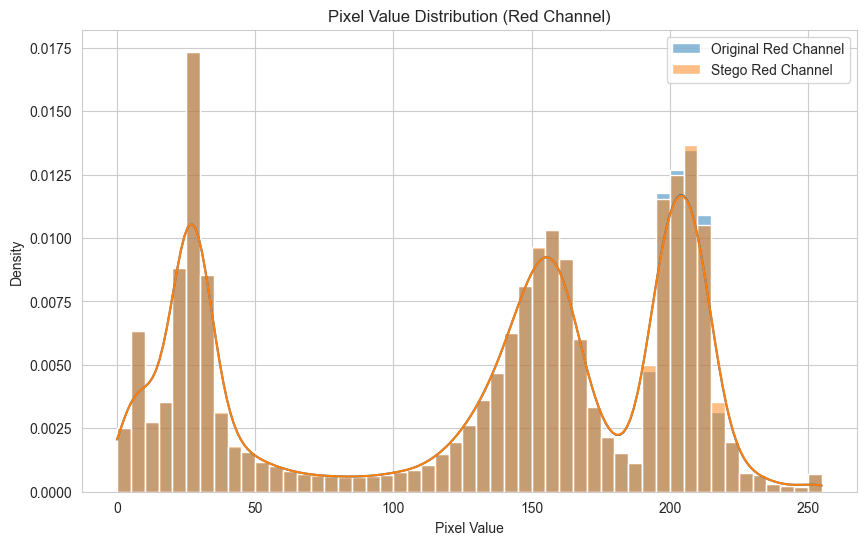

In [12]:
plt.figure()
sns.histplot(img_arr[:, :, 0].flatten(), kde=True, label='Original Red Channel', stat='density')
sns.histplot(stego_arr[:, :, 0].flatten(), kde=True, label='Stego Red Channel', stat='density')
plt.title('Pixel Value Distribution (Red Channel)')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# <a id='toc11_'></a>[Step 10: LSB planes visualization](#toc0_)

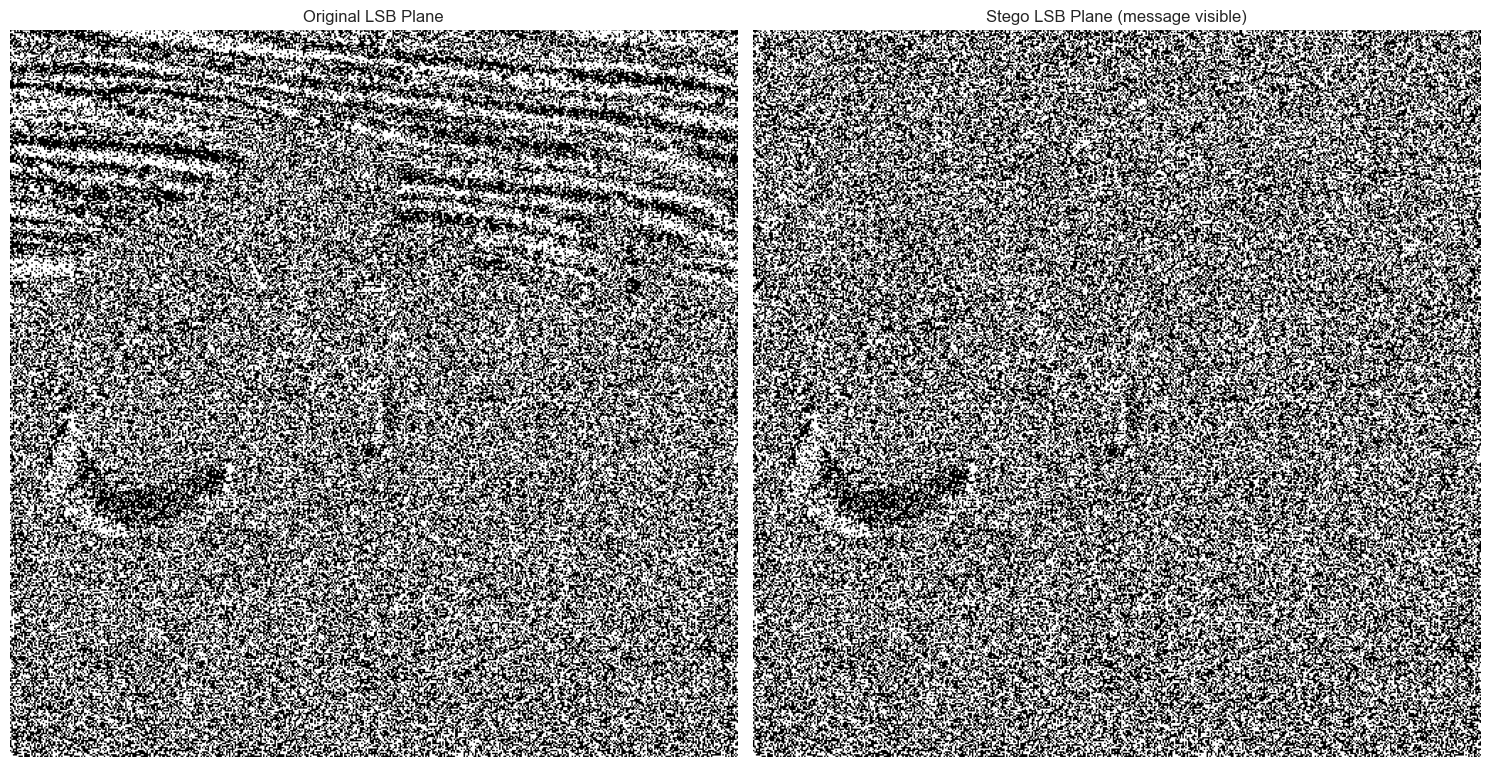


Steganography demonstration complete!


In [13]:
def get_lsb_plane(image_array):
    """Extract LSB plane of red channel."""
    red_channel = image_array[:, :, 0]
    return (red_channel & 1) * 255  # Scale to 0-255

original_lsb = get_lsb_plane(img_arr)
stego_lsb = get_lsb_plane(stego_arr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(original_lsb, cmap='gray')
ax1.set_title('Original LSB Plane')
ax1.axis('off')

ax2.imshow(stego_lsb, cmap='gray')
ax2.set_title('Stego LSB Plane (message visible)')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\nSteganography demonstration complete!")